In [1]:
#Initial imports
#Y will always be target
#One model with all 3 features
#One model with fng and price
#One model with pytrends and price
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load the fear and greed sentiment data for Bitcoin
fng_df = pd.read_csv('../resources/fng.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
fng_df = fng_df.rename(columns={'value':'fng'})
fng_df

,fng
date,
2022-04-07,34
2022-04-06,48
2022-04-05,53
2022-04-04,52
2022-04-03,48
...,...
2021-10-11,71
2021-10-10,71
2021-10-09,72


In [4]:
# Load the historical closing prices for Bitcoin
price_df = pd.read_csv('../resources/BTC-USD.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
price_df = price_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'])
price_df = price_df.rename(columns={'Close':'close'})
price_df

,close
Date,
2021-10-04,49112.90234
2021-10-05,51514.81250
2021-10-06,55361.44922
2021-10-07,53805.98438
2021-10-08,53967.84766
...,...
2022-03-30,47062.66406
2022-03-31,45538.67578
2022-04-01,46281.64453


In [5]:
# Join the data into a single DataFrame
join_df = pd.concat([price_df, fng_df], axis=1, join="inner")
join_df

,close,fng
2021-10-07,53805.98438,76
2021-10-08,53967.84766,74
2021-10-09,54968.22266,72
2021-10-10,54771.57813,71
2021-10-11,57484.78906,71
...,...,...
2022-03-30,47062.66406,55
2022-03-31,45538.67578,52
2022-04-01,46281.64453,50
2022-04-02,45868.94922,52


In [6]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [7]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fear and greed' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 0
X, y = window_data(join_df, window_size, feature_column, target_column)

In [8]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [9]:
# Use the MinMaxScaler to scale data between 0 and 1.
# Create MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with training feature data X_train
scaler.fit(X_train)

# Scale features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit MinMaxScaler object with training target data y_train
scaler.fit(y_train)

# Scale target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Defining LSTM RNN model
def createLstmModel():
    keras.backend.clear_session()
    model = Sequential()

    number_units = 5
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))

    return model

# Create a Dataframe with Real vs. Predicted data
def createRealPredictedDataFrame(model, X_test, y_test):
    # Make some predictions
    predicted = model.predict(X_test)

    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Create a DataFrame of Real and Predicted values
    real_predicted_prices_df = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index = join_df.index[-len(real_prices): ]) 
    
    return real_predicted_prices_df  

# Compile, Fit, and Evaluate Model
def compileFitEvaluateLstmModel(numEpochs):     
    # Compile the model
    model = createLstmModel()
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Summarize the model
    model.summary()

    # Train the model
    model.fit(X_train, y_train, epochs=numEpochs, shuffle=False, batch_size=1, verbose=1)

    # Evaluate the model
    model.evaluate(X_test, y_test)  

    return model  

# 10 Epochs

In [12]:
# Compile the model
numEpochs = 10
model = compileFitEvaluateLstmModel(numEpochs)

2022-04-14 00:07:40.825446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 5)             140       
_________________________________________________________________
dropout (Dropout)            (None, 10, 5)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 5)             220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

2022-04-14 00:07:41.470652: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


117/117 [==============================] - 4s 7ms/step - loss: 0.2516
Epoch 2/10
117/117 [==============================] - 1s 7ms/step - loss: 0.0939
Epoch 3/10
117/117 [==============================] - 1s 6ms/step - loss: 0.0779
Epoch 4/10
117/117 [==============================] - 1s 6ms/step - loss: 0.0454
Epoch 5/10
117/117 [==============================] - 1s 6ms/step - loss: 0.0342
Epoch 6/10
117/117 [==============================] - 1s 6ms/step - loss: 0.0334
Epoch 7/10
117/117 [==============================] - 1s 6ms/step - loss: 0.0273
Epoch 8/10
117/117 [==============================] - 1s 6ms/step - loss: 0.0323
Epoch 9/10
117/117 [==============================] - 1s 6ms/step - loss: 0.0210
Epoch 10/10
2/2 [==============================] - 1s 5ms/step - loss: 0.0237


In [13]:
# Create Real vs. Predicted Dataframe
real_predicted_prices_df = createRealPredictedDataFrame(model, X_test, y_test)
real_predicted_prices_df

,Real,Predicted
2022-02-12,42407.93750,42758.914062
2022-02-13,42244.46875,43822.148438
2022-02-14,42197.51563,44987.152344
2022-02-15,42586.91797,46732.414062
2022-02-16,44575.20313,48496.531250
2022-02-17,43961.85938,49405.007812
2022-02-18,40538.01172,50024.597656
2022-02-19,40030.97656,50153.070312
2022-02-20,40122.15625,50009.531250
2022-02-21,38431.37891,49362.988281


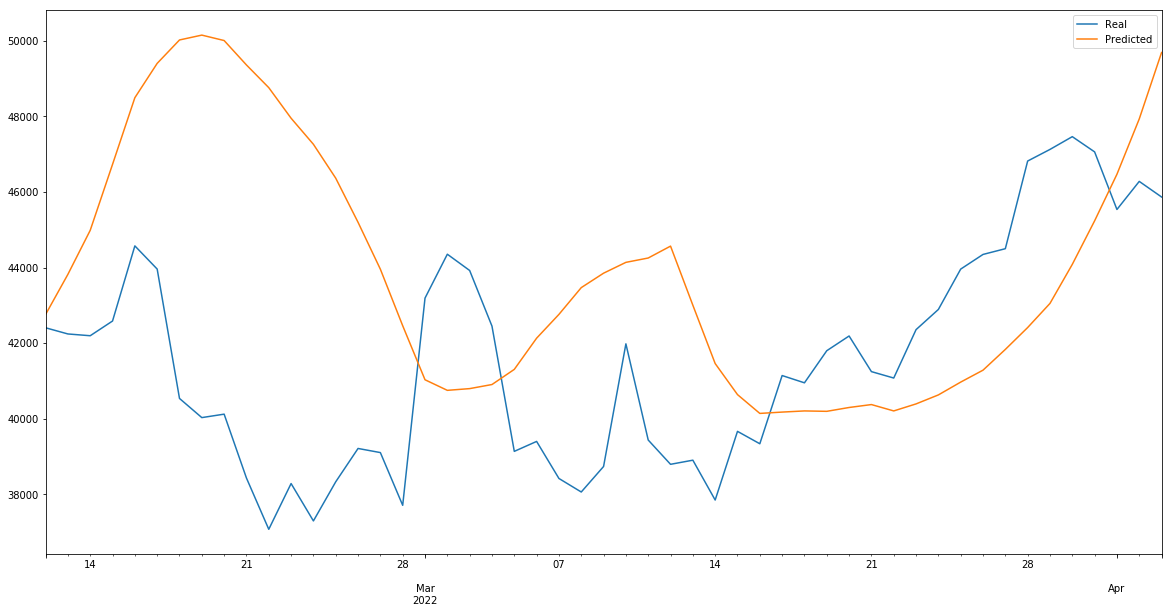

In [14]:
# Plot the real vs predicted values as a line chart
real_predicted_prices_df.plot(figsize=(20,10))

# 100 Epochs

In [15]:
numEpochs = 100
model = compileFitEvaluateLstmModel(numEpochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 5)             140       
_________________________________________________________________
dropout (Dropout)            (None, 10, 5)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 5)             220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [16]:
# Create Real vs. Predicted Dataframe
real_predicted_prices_df2 = createRealPredictedDataFrame(model, X_test, y_test)
real_predicted_prices_df2

,Real,Predicted
2022-02-12,42407.93750,49754.054688
2022-02-13,42244.46875,51570.562500
2022-02-14,42197.51563,52917.562500
2022-02-15,42586.91797,53934.089844
2022-02-16,44575.20313,54625.847656
2022-02-17,43961.85938,54906.582031
2022-02-18,40538.01172,55097.675781
2022-02-19,40030.97656,55182.589844
2022-02-20,40122.15625,54855.964844
2022-02-21,38431.37891,54033.308594


<AxesSubplot:>

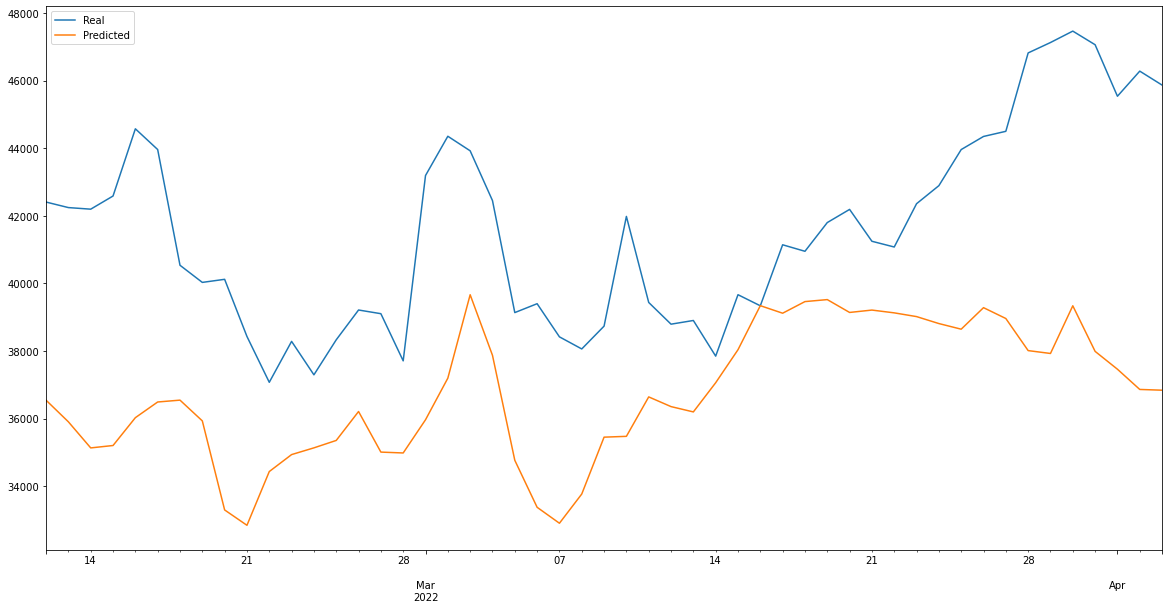

In [19]:
# Plot the real vs predicted values as a line chart
real_predicted_prices_df.plot(figsize=(20,10))

# 300 Epochs

In [17]:
numEpochs = 300
model = compileFitEvaluateLstmModel(numEpochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 5)             140       
_________________________________________________________________
dropout (Dropout)            (None, 10, 5)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 5)             220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [18]:
# Create Real vs. Predicted Dataframe
real_predicted_prices_df3 = createRealPredictedDataFrame(model, X_test, y_test)
real_predicted_prices_df3

,Real,Predicted
2022-02-12,42407.93750,49687.230469
2022-02-13,42244.46875,51073.480469
2022-02-14,42197.51563,52179.105469
2022-02-15,42586.91797,53201.050781
2022-02-16,44575.20313,53910.378906
2022-02-17,43961.85938,54250.609375
2022-02-18,40538.01172,54681.515625
2022-02-19,40030.97656,55074.410156
2022-02-20,40122.15625,54475.312500
2022-02-21,38431.37891,53124.437500


In [19]:
# Export these prices to CSV for Chart Overlay
real_predicted_prices_df3.to_csv(Path("../resources/fng.csv"))

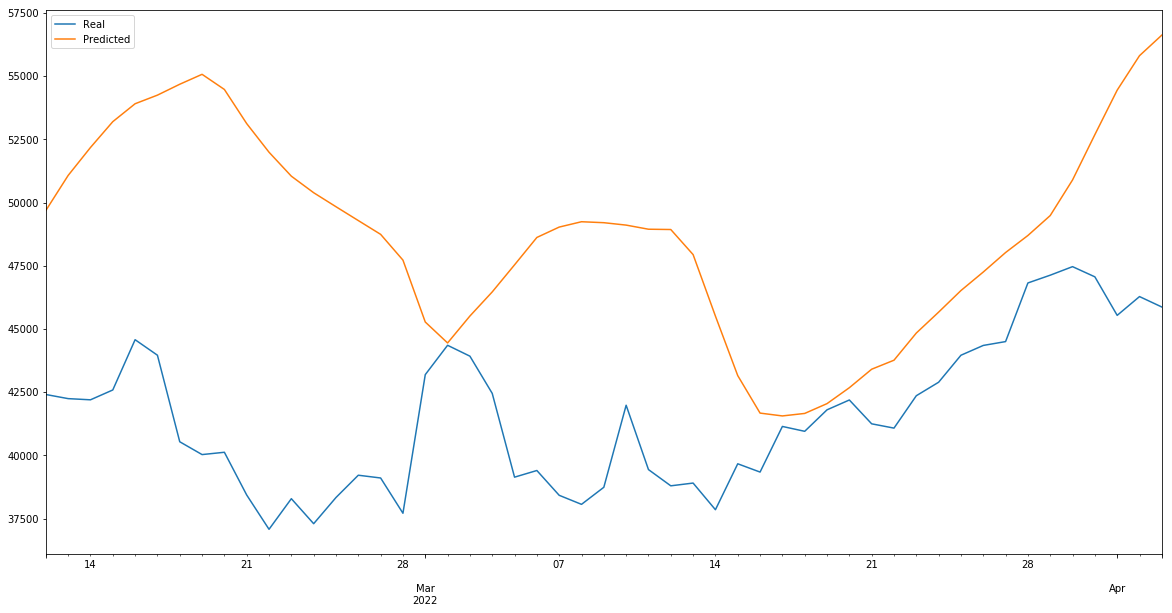

In [20]:
# Plot the real vs predicted values as a line chart
real_predicted_prices_df3.plot(figsize=(20,10))

# 500 Epochs

In [23]:
numEpochs = 500
model = compileFitEvaluateLstmModel(numEpochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 5)             140       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [24]:
# Create Real vs. Predicted Dataframe
real_predicted_prices_df = createRealPredictedDataFrame(model, X_test, y_test)
real_predicted_prices_df

,Real,Predicted
2022-02-12,42407.93750,39862.531250
2022-02-13,42244.46875,40496.363281
2022-02-14,42197.51563,42456.707031
2022-02-15,42586.91797,44879.035156
2022-02-16,44575.20313,45817.882812
2022-02-17,43961.85938,46437.683594
2022-02-18,40538.01172,46194.332031
2022-02-19,40030.97656,46145.398438
2022-02-20,40122.15625,46272.835938
2022-02-21,38431.37891,46716.347656


<AxesSubplot:>

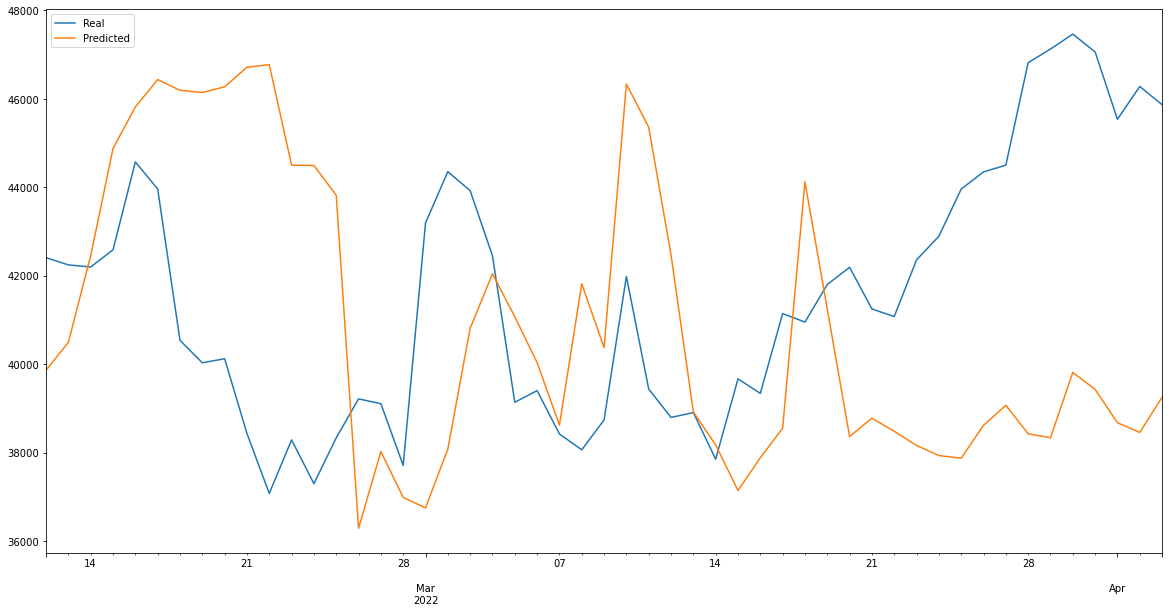

In [25]:
# Plot the real vs predicted values as a line chart
real_predicted_prices_df.plot(figsize=(20,10))

# 1000 Epochs

In [26]:
numEpochs = 1000
model = compileFitEvaluateLstmModel(numEpochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 5)             140       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [27]:
# Create Real vs. Predicted Dataframe
real_predicted_prices_df = createRealPredictedDataFrame(model, X_test, y_test)
real_predicted_prices_df

,Real,Predicted
2022-02-12,42407.93750,41161.199219
2022-02-13,42244.46875,40216.042969
2022-02-14,42197.51563,43770.066406
2022-02-15,42586.91797,39508.675781
2022-02-16,44575.20313,38778.421875
2022-02-17,43961.85938,45154.441406
2022-02-18,40538.01172,45799.742188
2022-02-19,40030.97656,44496.929688
2022-02-20,40122.15625,44013.636719
2022-02-21,38431.37891,42523.351562


<AxesSubplot:>

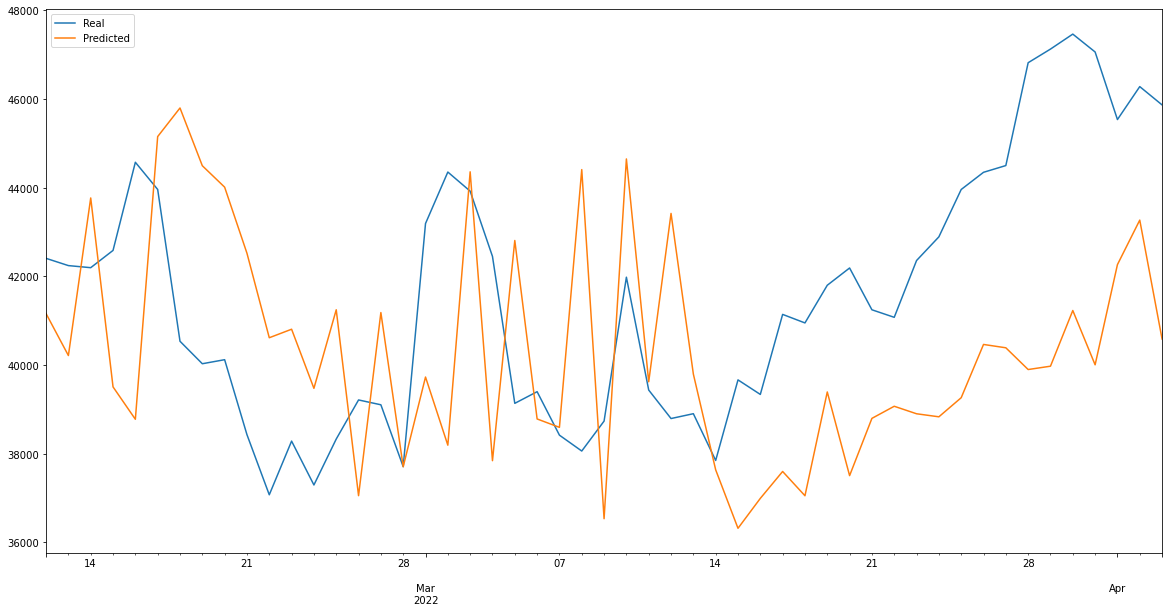

In [28]:
# Plot the real vs predicted values as a line chart
real_predicted_prices_df.plot(figsize=(20,10))